# Model SBC Report

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import re
import warnings
from pathlib import Path
from time import time
from typing import Dict, List, Tuple

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

from src.command_line_interfaces import cli_helpers
from src.loggers import set_console_handler_level
from src.managers.model_cache_managers import Pymc3ModelCacheManager
from src.modeling import pymc3_analysis as pmanal
from src.modeling import simulation_based_calibration_helpers as sbc
from src.project_enums import ModelFitMethod

In [3]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

set_console_handler_level(logging.WARNING)
pymc3_cache_dir = Path("..", "models", "modeling_cache", "pymc3_model_cache")

Parameters for papermill:

- `MODEL_NAME`: unique, identifiable name of the model
- `SBC_RESULTS_DIR`: directory containing results of many rounds of SBC
- `SBC_COLLATED_RESULTS`: path to collated simulation posteriors
- `NUM_SIMULATIONS`: the number of simiulations; will be used to check that all results are found
- `CONFIG_PATH`: path to the model configuration file
- `FIT_METHOD`: model fitting method used for this SBC

## Setup

### Papermill parameters

In [4]:
MODEL_NAME = ""
SBC_RESULTS_DIR = ""
SBC_COLLATED_RESULTS = ""
NUM_SIMULATIONS = -1
CONFIG_PATH = ""
FIT_METHOD_STR = ""

In [5]:
# Parameters
MODEL_NAME = "sp2-default"
SBC_RESULTS_DIR = "/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC"
SBC_COLLATED_RESULTS = (
    "cache/sbc-cache/sp2-default_MCMC_collated-posterior-summaries.pkl"
)
NUM_SIMULATIONS = 25
CONFIG_PATH = "models/model-configs.yaml"
FIT_METHOD_STR = "MCMC"

### Prepare and validate papermill parameters

Check values passed as the directory with results of the rounds of SBC.

In [6]:
path_addition = "../.."

sbc_results_dir = Path(path_addition, SBC_RESULTS_DIR)
assert sbc_results_dir.is_dir()
assert sbc_results_dir.exists()

sbc_collated_results_path = Path(path_addition, SBC_COLLATED_RESULTS)
assert sbc_collated_results_path.is_file()
assert sbc_collated_results_path.exists()

Confirm that there is a positive number of simulations.

In [7]:
assert NUM_SIMULATIONS > 0

In [8]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)

## Read in all results

In [9]:
simulation_posteriors_df = pd.read_pickle(sbc_collated_results_path)
simulation_posteriors_df.head()

,,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value,simulation_id,within_hdi
parameter,parameter_name,,,,,,,,,,,,
μ_α,μ_α,0.768,0.103,0.590,0.919,0.020,0.014,27.0,30.0,1.61,0.882026,sim_id_0000,True
"α[0,0]",α,1.151,0.134,0.926,1.355,0.022,0.016,36.0,50.0,1.49,1.273675,sim_id_0000,True
"α[0,1]",α,1.627,0.130,1.449,1.865,0.024,0.017,34.0,58.0,1.08,1.778736,sim_id_0000,True
"α[0,2]",α,1.617,0.177,1.408,1.867,0.064,0.049,9.0,23.0,1.37,1.629343,sim_id_0000,True
"α[0,3]",α,0.385,0.133,0.162,0.559,0.031,0.022,23.0,65.0,1.13,0.490961,sim_id_0000,True


## Analysis

### ADVI approximation histories

In [10]:
if FIT_METHOD is ModelFitMethod.ADVI:
    advi_histories: List[np.ndarray] = []

    for dir in sbc_results_dir.iterdir():
        if not dir.is_dir():
            continue

        cache_manager = Pymc3ModelCacheManager(name=MODEL_NAME, root_cache_dir=dir)
        if cache_manager.advi_cache_exists():
            _, advi_approx = cache_manager.get_advi_cache()
            advi_histories.append(advi_approx.hist)
    n_sims_advi_hist = min(NUM_SIMULATIONS, 5)
    sample_hist_idxs = np.random.choice(
        list(range(len(advi_histories))), size=n_sims_advi_hist, replace=False
    )

    def make_hist_df(sim_idx: int, hist_list: List[np.ndarray]) -> pd.DataFrame:
        df = pd.DataFrame({"sim_idx": sim_idx, "loss": hist_list[sim_idx].flatten()})
        df["step"] = np.arange(df.shape[0])
        return df

    sampled_advi_histories = pd.concat(
        [make_hist_df(i, advi_histories) for i in sample_hist_idxs]
    ).reset_index(drop=True)

    (
        gg.ggplot(
            sampled_advi_histories,
            gg.aes(x="step", y="np.log(loss)", color="factor(sim_idx)"),
        )
        + gg.geom_line(alpha=0.5)
        + gg.scale_color_brewer(type="qual", palette="Set1")
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0.01, 0, 0.02, 0))
        + gg.theme(legend_position=(0.8, 0.5))
        + gg.labs(y="log loss", color="sim. idx.")
    ).draw()
    plt.show()

### MCMC diagnostics

sbc-perm15
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 70, 226, 45, 265
percent divergences: 0.07, 0.226, 0.045, 0.265
BFMI: 0.305, 0.381, 0.274, 0.405
avg. step size: 0.094, 0.061, 0.055, 0.059


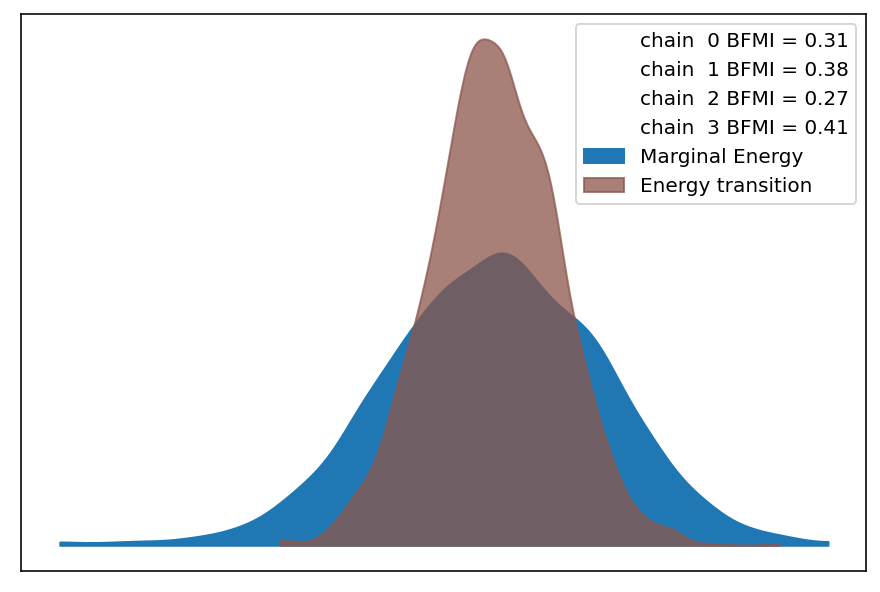

sbc-perm8
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 1000, 135, 170, 215
percent divergences: 1.0, 0.135, 0.17, 0.215
BFMI: 1.255, 0.233, 0.254, 0.263
avg. step size: 0.024, 0.057, 0.014, 0.03


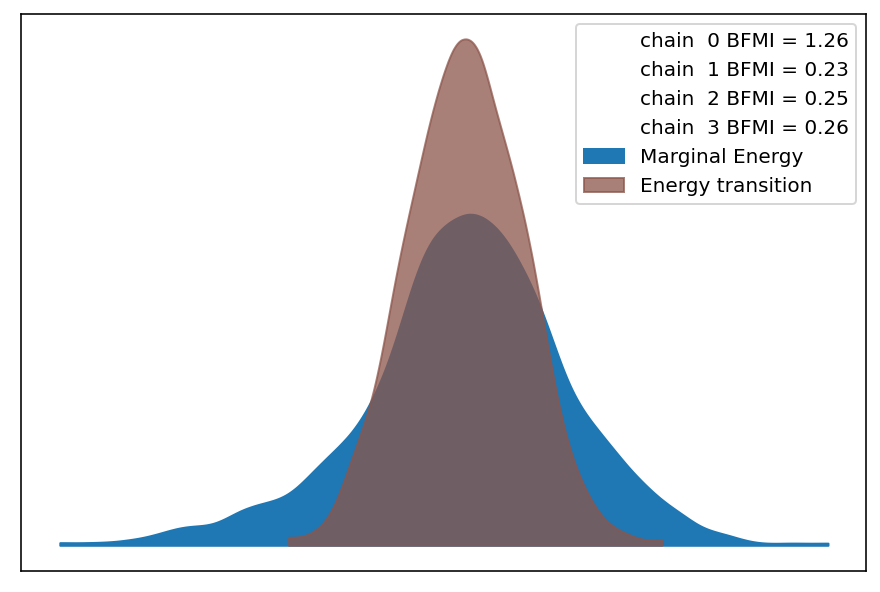

sbc-perm20
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 65, 66, 79, 160
percent divergences: 0.065, 0.066, 0.079, 0.16
BFMI: 0.378, 0.332, 0.294, 0.272
avg. step size: 0.051, 0.051, 0.111, 0.088


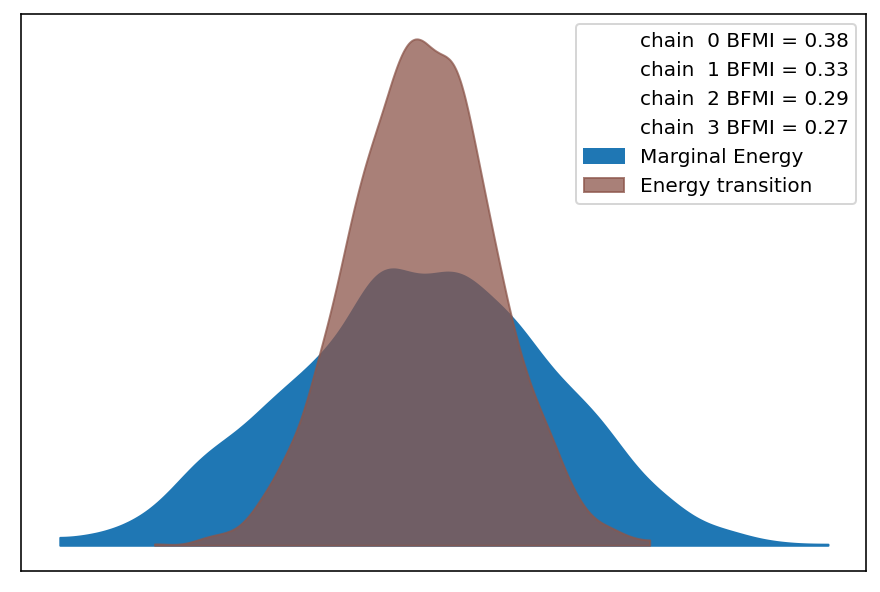

sbc-perm5
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 24, 67, 66, 43
percent divergences: 0.024, 0.067, 0.066, 0.043
BFMI: 0.264, 0.429, 0.303, 0.339
avg. step size: 0.012, 0.037, 0.059, 0.067


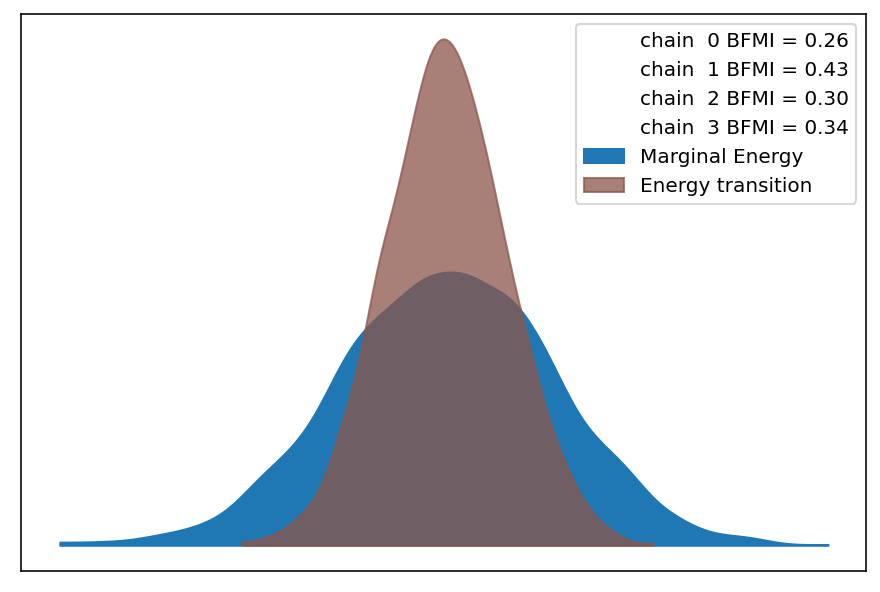

sbc-perm14
------------------------------
sampled 4 chains with (unknown) tuning steps and 1,000 draws
num. divergences: 1000, 731, 278, 47
percent divergences: 1.0, 0.731, 0.278, 0.047
BFMI: 1.646, 0.383, 0.303, 0.292
avg. step size: 0.006, 0.012, 0.017, 0.021


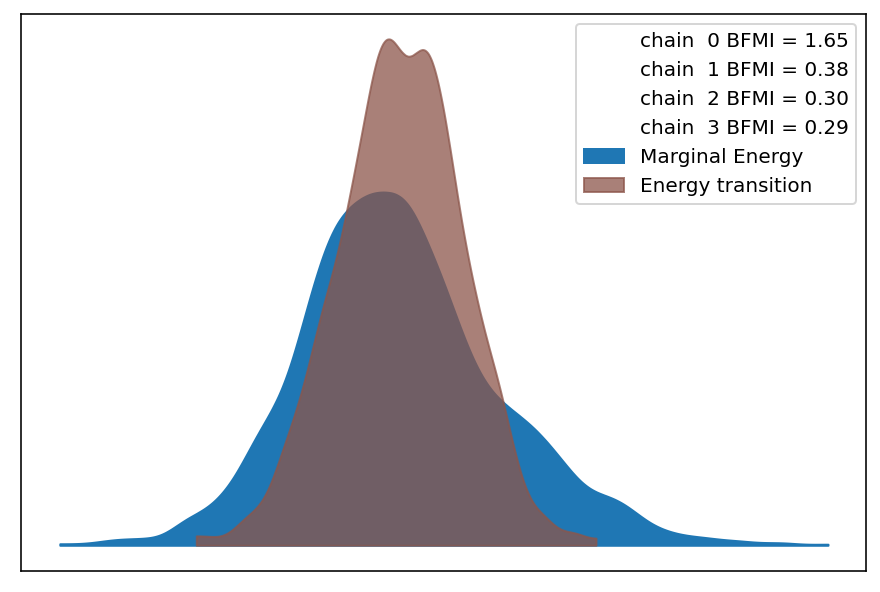

In [11]:
class IncompleteCachedResultsWarning(UserWarning):
    pass


all_sbc_perm_dirs = list(sbc_results_dir.iterdir())

for perm_dir in np.random.choice(
    all_sbc_perm_dirs, size=min([5, len(all_sbc_perm_dirs)]), replace=False
):
    print(perm_dir.name)
    print("-" * 30)
    sbc_fm = sbc.SBCFileManager(perm_dir)
    if sbc_fm.all_data_exists():
        sbc_res = sbc_fm.get_sbc_results()
        _ = pmanal.describe_mcmc(sbc_res.inference_obj)
    else:
        warnings.warn(
            "Cannot find all components of the SBC results.",
            IncompleteCachedResultsWarning,
        )

### Estimate accuracy

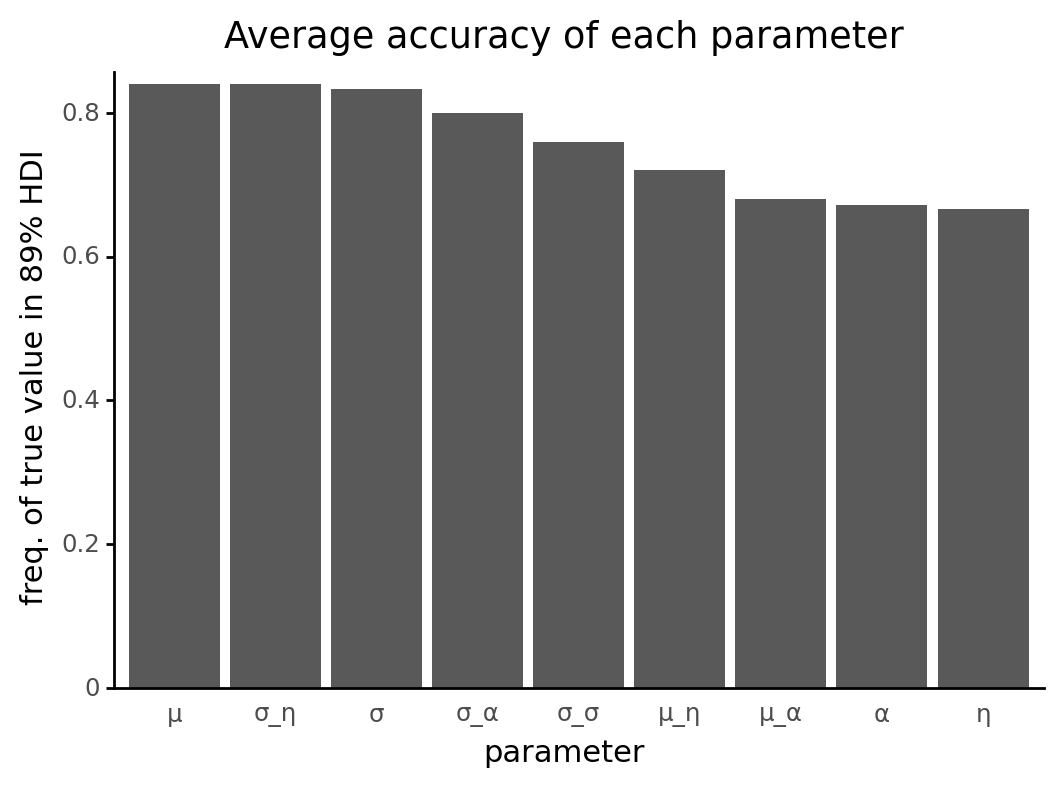

<ggplot: (8794698579622)>

In [12]:
accuracy_per_parameter = (
    simulation_posteriors_df.copy()
    .groupby(["parameter_name"])["within_hdi"]
    .mean()
    .reset_index(drop=False)
    .sort_values("within_hdi", ascending=False)
    .reset_index(drop=True)
)

accuracy_per_parameter["parameter_name"] = pd.Categorical(
    accuracy_per_parameter["parameter_name"],
    categories=accuracy_per_parameter["parameter_name"].values,
)

(
    gg.ggplot(accuracy_per_parameter, gg.aes(x="parameter_name", y="within_hdi"))
    + gg.geom_col()
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(
        x="parameter",
        y="freq. of true value in 89% HDI",
        title="Average accuracy of each parameter",
    )
    + gg.theme(axis_ticks_major_x=gg.element_blank(), figure_size=(6, 4))
)

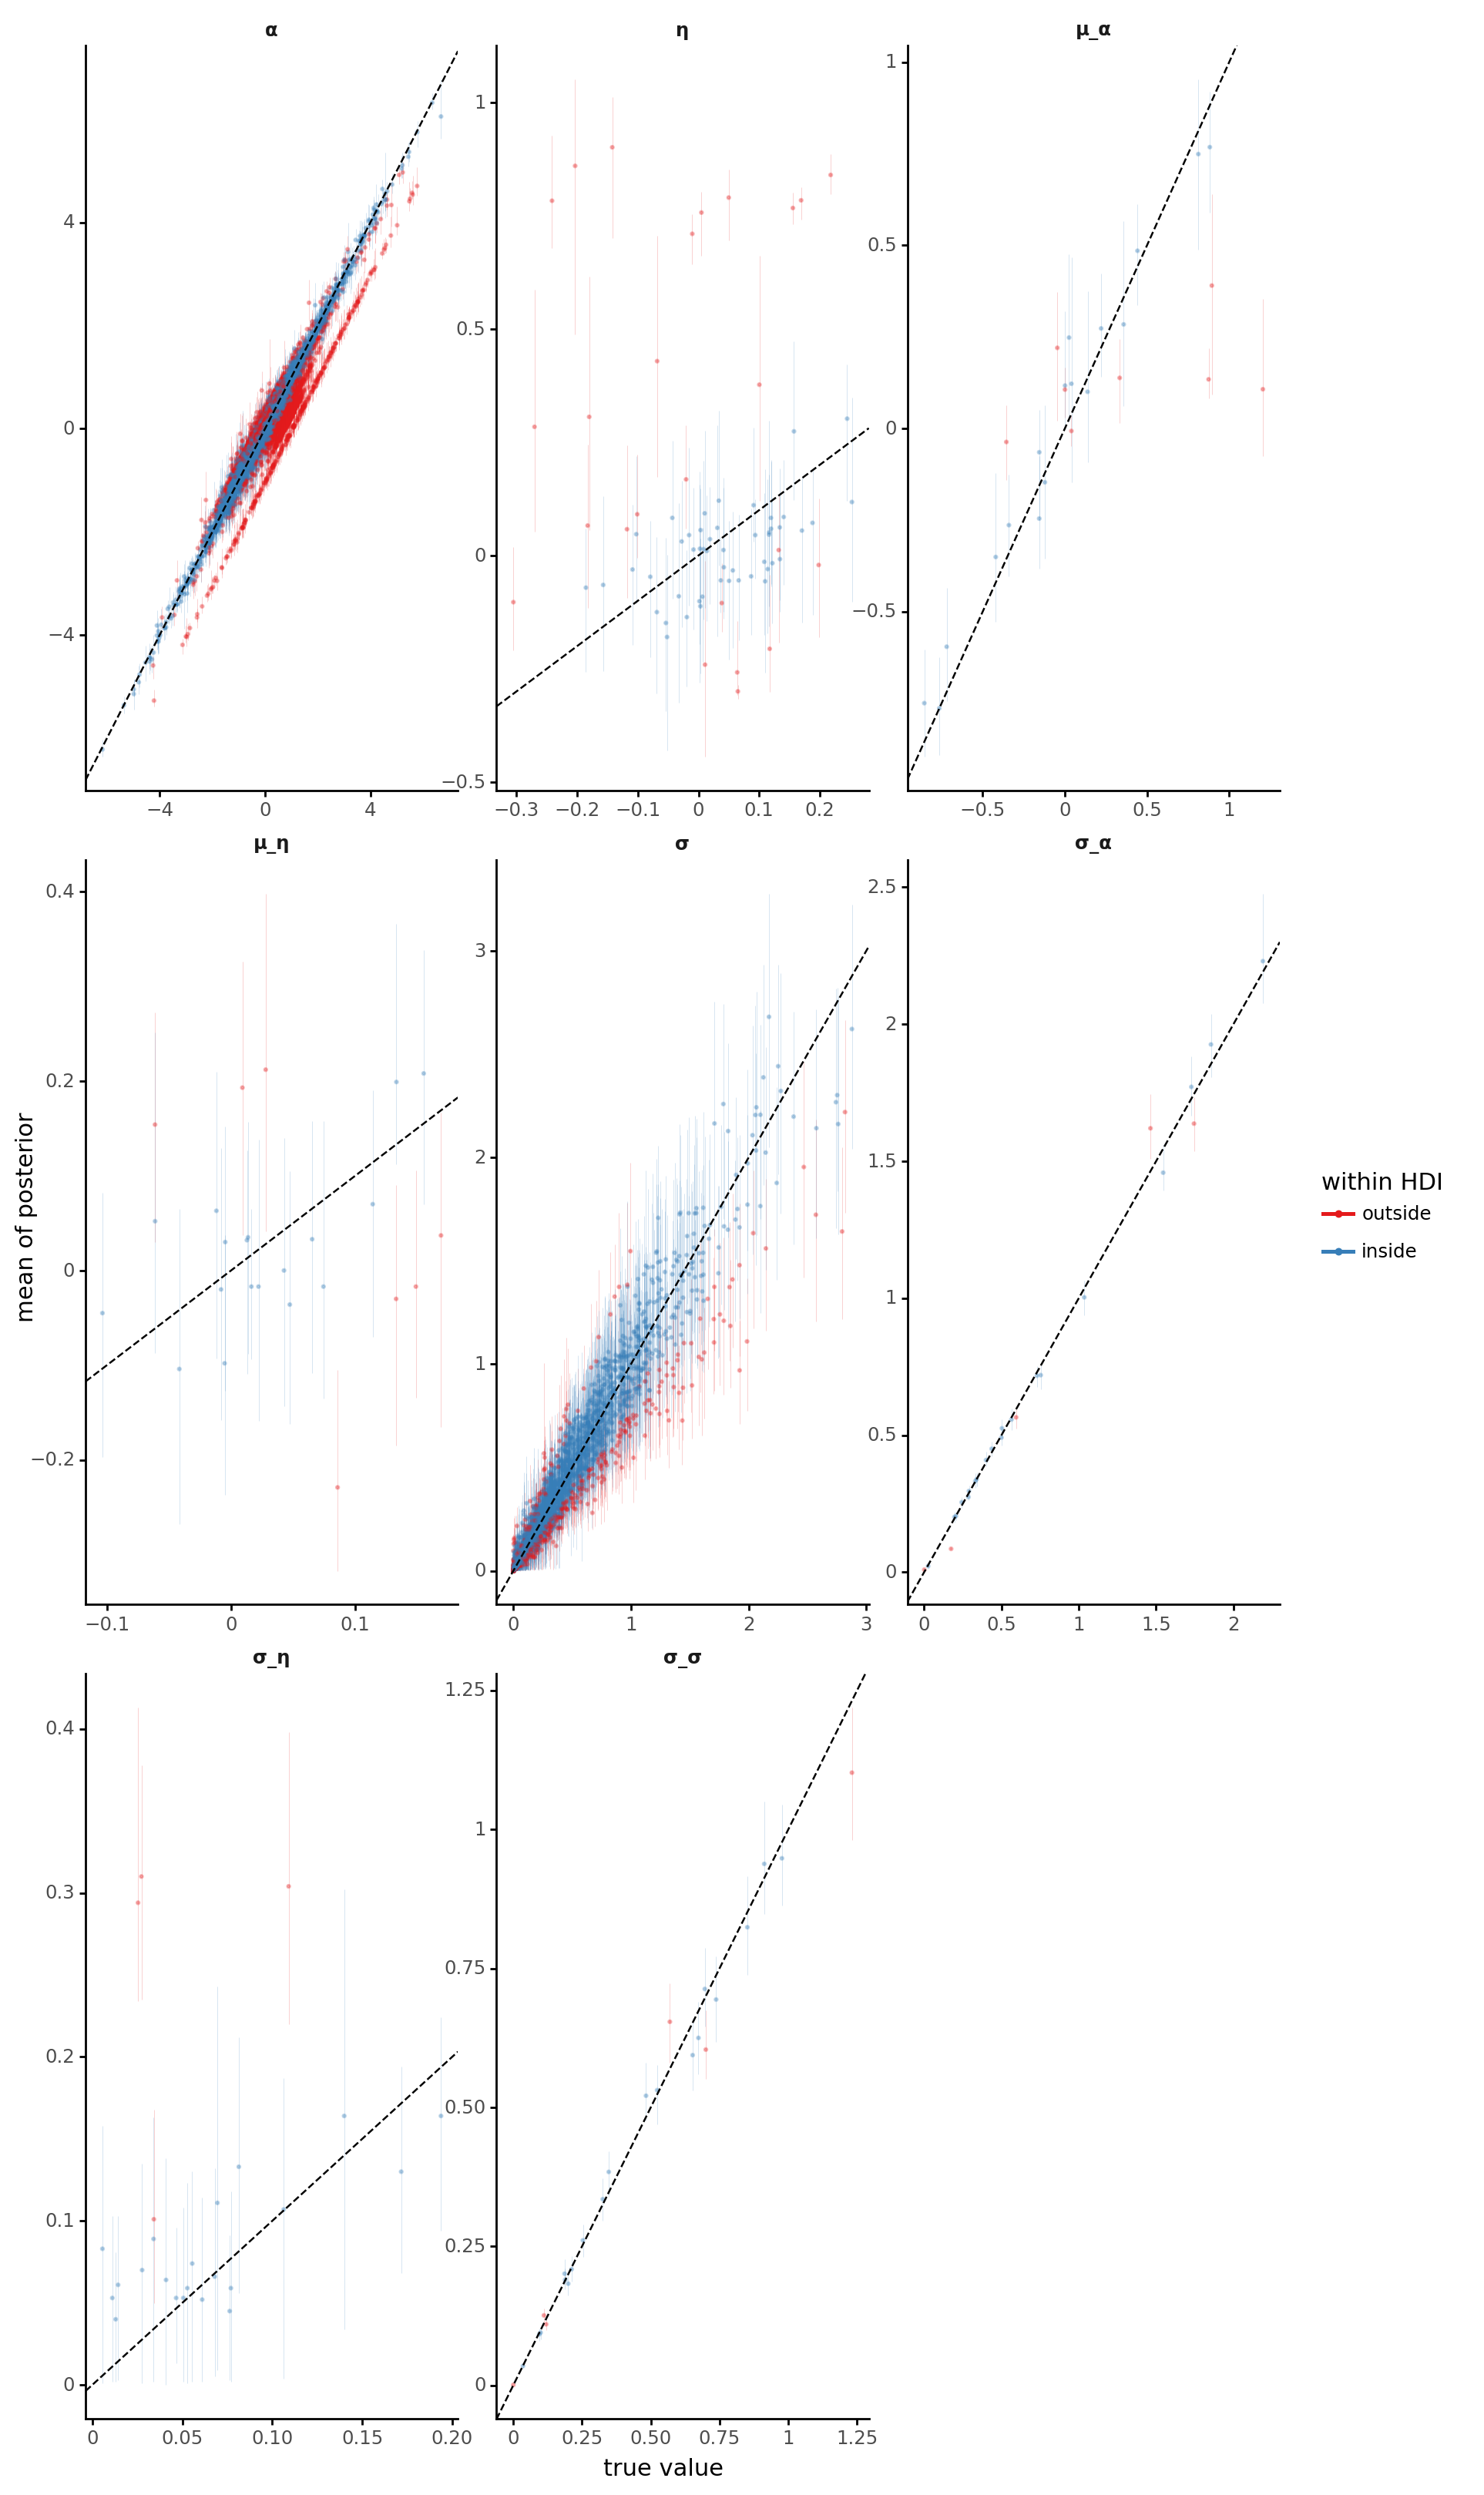

<ggplot: (8794698536945)>

In [13]:
hdi_low, hdi_high = pmanal.get_hdi_colnames_from_az_summary(simulation_posteriors_df)


def filter_uninsteresting_parameters(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.reset_index(drop=False)
        .query("parameter_name != 'μ'")
        .filter_string("parameter_name", search_string="offset", complement=True)
    )


(
    gg.ggplot(
        filter_uninsteresting_parameters(simulation_posteriors_df),
        gg.aes(x="true_value", y="mean", color="within_hdi"),
    )
    + gg.facet_wrap("~ parameter_name", ncol=3, scales="free")
    + gg.geom_linerange(gg.aes(ymin=hdi_low, ymax=hdi_high), alpha=0.2, size=0.2)
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.geom_abline(slope=1, intercept=0, linetype="--")
    + gg.scale_color_brewer(
        type="qual",
        palette="Set1",
        labels=("outside", "inside"),
        guide=gg.guide_legend(
            title="within HDI",
            override_aes={"alpha": 1, "size": 1},
        ),
    )
    + gg.theme(
        figure_size=(10, 20),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
        panel_spacing=0.25,
    )
    + gg.labs(
        x="true value",
        y="mean of posterior",
    )
)

## Experimenting with uniformity check for SBC

In [14]:
sbc_analyzer = sbc.SBCAnalysis(
    root_dir=sbc_results_dir, pattern="sbc-perm", n_simulations=NUM_SIMULATIONS
)

In [15]:
sbc_file_managers = sbc_analyzer.get_simulation_file_managers()
sbc_file_managers[:3]

In [16]:
sbc_fm = sbc_file_managers[0]
sbc_fm.dir

PosixPath('/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC/sbc-perm0')

In [17]:
sbc_res = sbc_fm.get_sbc_results()
sbc_res.inference_obj

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [18]:
sbc_res.priors["μ_α"].shape, sbc_res.inference_obj["posterior"]["μ_α"].shape

((1,), (4, 1000))

In [19]:
sbc_res.priors["α"].shape, sbc_res.inference_obj["posterior"]["α"].shape

((1, 25, 12), (4, 1000, 25, 12))

In [20]:
sbc_res.priors.keys()

dict_keys(['σ', 'σ_σ', 'α', 'σ_α_log__', 'μ', 'lfc', 'σ_α', 'σ_log__', 'σ_η_log__', 'μ_α', 'σ_η', 'μ_η', 'σ_σ_log__', 'η'])

In [21]:
var_names = list(sbc_res.inference_obj["posterior"].data_vars)
var_names

['μ_α', 'α', 'μ_η', 'η', 'σ_α', 'σ_η', 'μ', 'σ_σ', 'σ']

In [22]:
from math import floor

import xarray as xr

In [23]:
def thin_posterior(posterior: xr.DataArray, thin_to: int = 100) -> xr.DataArray:
    thinning_step = floor(posterior.shape[1] / thin_to)
    return posterior.sel(draw=slice(0, None, thinning_step))


def get_one_chain(posterior: xr.DataArray) -> xr.DataArray:
    return posterior.sel(chain=0)


def fmt_tuple_to_label(tpl: tuple[int, ...]) -> str:
    if len(tpl) > 0:
        return "[" + ",".join([str(i) for i in tpl]) + "]"
    else:
        return ""


def rank_statistic_to_dataframe(var_name: str, rank_stats: np.ndarray) -> pd.DataFrame:
    params: list[str] = []
    values: list[float] = []
    for idx, value in np.ndenumerate(rank_stats.squeeze()):
        params.append(var_name + fmt_tuple_to_label(idx))
        values.append(value)
    return pd.DataFrame({"parameter": params, "rank_stat": values})


def calculate_parameter_rank_statistic(
    sbc_res: sbc.SBCResults, thin_to: int = 100
) -> pd.DataFrame:
    rank_stats_df = pd.DataFrame()

    for var_name in var_names:
        theta = sbc_res.priors[var_name]
        theta_prime = sbc_res.inference_obj["posterior"][var_name]
        theta_prime = thin_posterior(theta_prime, thin_to=thin_to)
        theta_prime = get_one_chain(theta_prime)
        rank_stat = (theta < theta_prime).values.sum(axis=0, keepdims=True)
        stat_df = rank_statistic_to_dataframe(var_name, rank_stat)
        rank_stats_df = pd.concat([rank_stats_df, stat_df])

    rank_stats_df = rank_stats_df.reset_index(drop=True)
    return rank_stats_df

In [24]:
rank_stats = pd.concat(
    [
        calculate_parameter_rank_statistic(fm.get_sbc_results())
        for fm in sbc_file_managers
    ]
)

In [25]:
rank_stats.shape

(48325, 2)

In [26]:
def expected_range_under_uniform(
    n_sims: int, k_draws: int
) -> tuple[float, float, float]:
    x = np.random.beta(1, 1, size=n_sims)
    bins = [i / k_draws for i in range(k_draws + 1)]
    hist = np.histogram(x, bins)
    # Expected value.
    expected = n_sims / k_draws
    sd = np.sqrt((1 / k_draws) * (1 - 1 / k_draws) * n_sims)
    # 95% CI.
    upper = expected + 1.96 * sd
    lower = expected - 1.96 * sd
    return expected, lower, upper

In [31]:
expected, lower, upper = expected_range_under_uniform(
    n_sims=len(sbc_file_managers), k_draws=100
)

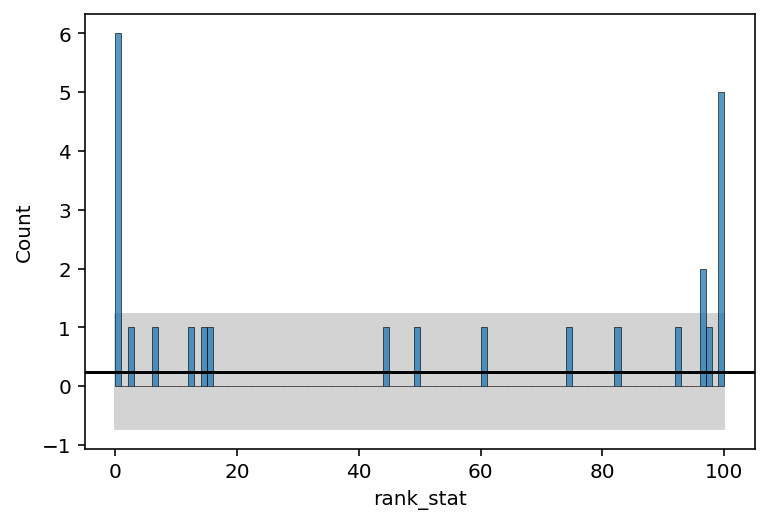

In [32]:
sns.histplot(data=rank_stats.query("parameter == 'μ_α'"), x="rank_stat", binwidth=1)
plt.fill_between(
    x=list(range(100 + 1)),
    y1=[lower] * (100 + 1),
    y2=[upper] * (100 + 1),
    color="#D3D3D3",
)
plt.axhline(expected, color="k", linestyle="-")
plt.show();

---

In [33]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.56 minutes


In [34]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-25

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-235.o2.rc.hms.harvard.edu

Git branch: sbc-uniform-check

numpy     : 1.20.1
xarray    : 0.18.2
seaborn   : 0.11.1
janitor   : 0.20.14
arviz     : 0.11.2
plotnine  : 0.7.1
re        : 2.2.1
logging   : 0.5.1.2
matplotlib: 3.3.4
pandas    : 1.2.3
pymc3     : 3.11.1

